# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [80]:
import tensorflow as tf

from tqdm import tqdm_notebook

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [81]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=10**4, random_state=42
)

class_names = np.array(
    [
        "airplane",
        "automobile ",
        "bird ",
        "cat ",
        "deer ",
        "dog ",
        "frog ",
        "horse ",
        "ship ",
        "truck",
    ]
)

print(X_train.shape, y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

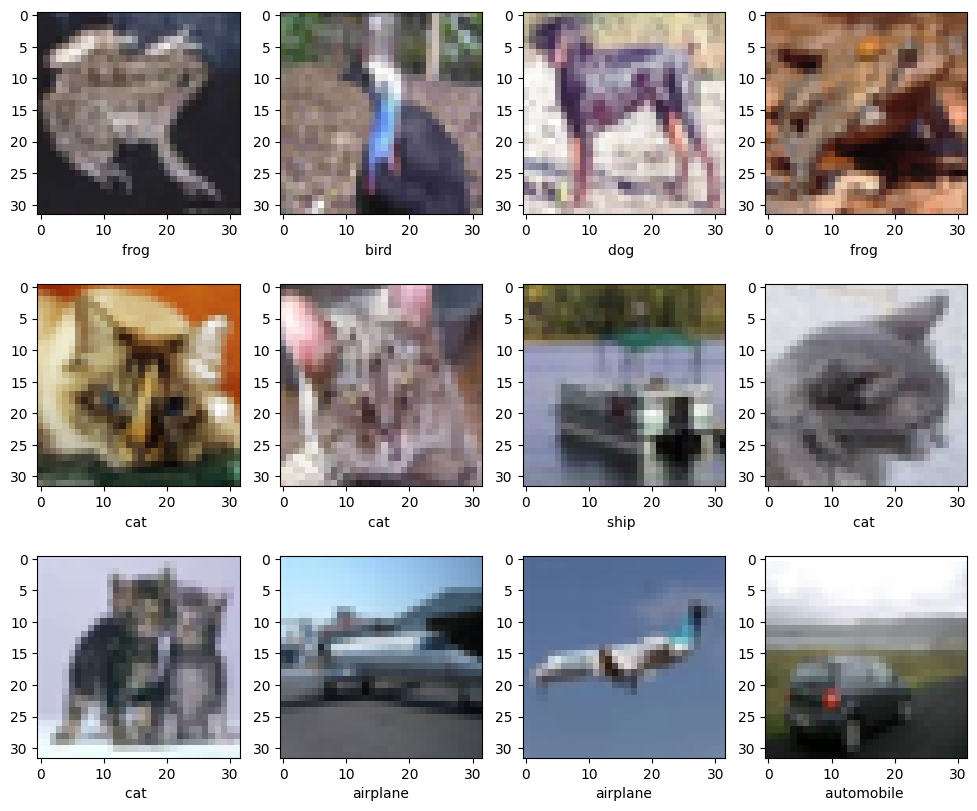

In [82]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=[12, 10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [83]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [84]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.0)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [85]:
import keras
from keras import layers as L
from keras import backend as K

In [86]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

/Users/eugene_ivanov/PycharmProjects/ds_python/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [87]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [88]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [89]:
# callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
#              tf.keras.callbacks.TensorBoard(log_dir='./logs'),
#              tf.keras.callbacks.EarlyStopping(patience=3)]

In [90]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="model.{epoch:02d}-{val_accuracy:.2f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
    ),
    tf.keras.callbacks.TensorBoard(log_dir="./logs"),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode="max"),
]

In [91]:
## TODO
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model_learning = history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=15,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
    verbose=1,
)

Epoch 1/15
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2294 - loss: 2.0869

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2862 - loss: 1.9702 - val_accuracy: 0.3290 - val_loss: 1.8381
Epoch 2/15
1238/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3570 - loss: 1.8059

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3660 - loss: 1.7734 - val_accuracy: 0.3755 - val_loss: 1.7245
Epoch 3/15
1237/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3989 - loss: 1.6760

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4060 - loss: 1.6637 - val_accuracy: 0.4025 - val_loss: 1.6304
Epoch 4/15
1235/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4280 - loss: 1.6029

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4294 - loss: 1.5952 - val_accuracy: 0.4220 - val_loss: 1.6247
Epoch 5/15
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4489 - loss: 1.5541

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4481 - loss: 1.5467 - val_accuracy: 0.4367 - val_loss: 1.5692
Epoch 6/15
1239/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4639 - loss: 1.5085

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4640 - loss: 1.5057 - val_accuracy: 0.4471 - val_loss: 1.5550
Epoch 7/15
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4765 - loss: 1.4728

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4768 - loss: 1.4732 - val_accuracy: 0.4634 - val_loss: 1.4959
Epoch 8/15
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4869 - loss: 1.4498

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4908 - loss: 1.4397 - val_accuracy: 0.4699 - val_loss: 1.4872
Epoch 9/15
1239/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4944 - loss: 1.4192

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4989 - loss: 1.4118 - val_accuracy: 0.4773 - val_loss: 1.4932
Epoch 10/15
1245/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5050 - loss: 1.3910

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5062 - loss: 1.3865 - val_accuracy: 0.4863 - val_loss: 1.4483
Epoch 11/15
1235/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5213 - loss: 1.3502

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5191 - loss: 1.3593 - val_accuracy: 0.4918 - val_loss: 1.4453
Epoch 12/15
1240/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5260 - loss: 1.3374

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5280 - loss: 1.3345 - val_accuracy: 0.4971 - val_loss: 1.4265
Epoch 13/15
1239/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5386 - loss: 1.3111

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5354 - loss: 1.3121 - val_accuracy: 0.5042 - val_loss: 1.4013
Epoch 14/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5445 - loss: 1.2901 - val_accuracy: 0.4869 - val_loss: 1.4441
Epoch 15/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5506 - loss: 1.2699 - val_accuracy: 0.4991 - val_loss: 1.4297


А теперь можно проверить качество вашей сети, выполнив код ниже:

In [92]:
from sklearn.metrics import accuracy_score

predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x, axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

 Test_acc = 0.5049
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [93]:
import tensorflow as tf
from tensorflow.keras import layers

## TODO
new_model = tf.keras.models.Sequential(
    [
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(10, (3, 3)),
        layers.Activation("relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(100),
        layers.Activation("relu"),
        layers.Dense(10),
        layers.Activation("softmax"),
    ]
)

In [94]:
new_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="new_model.{epoch:02d}-{val_loss:.2f}.h5"
    ),
    tf.keras.callbacks.TensorBoard(log_dir="./logs"),
    tf.keras.callbacks.EarlyStopping(patience=3),
]

In [95]:
## TODO
new_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
new_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=35,
    callbacks=new_callbacks,
    validation_split=0.2,
)

Epoch 1/35
1983/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3428 - loss: 1.8114

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4233 - loss: 1.6073 - val_accuracy: 0.4844 - val_loss: 1.4453
Epoch 2/35
1987/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5249 - loss: 1.3387

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5328 - loss: 1.3195 - val_accuracy: 0.5389 - val_loss: 1.2964
Epoch 3/35
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5699 - loss: 1.2194

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5743 - loss: 1.2111 - val_accuracy: 0.5555 - val_loss: 1.2679
Epoch 4/35
1979/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6008 - loss: 1.1352

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6026 - loss: 1.1308 - val_accuracy: 0.5691 - val_loss: 1.2151
Epoch 5/35
1987/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6319 - loss: 1.0622

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6285 - loss: 1.0648 - val_accuracy: 0.5573 - val_loss: 1.2452
Epoch 6/35
1994/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6483 - loss: 0.9940

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6475 - loss: 1.0047 - val_accuracy: 0.5842 - val_loss: 1.1946
Epoch 7/35
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6759 - loss: 0.9264

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6676 - loss: 0.9476 - val_accuracy: 0.5706 - val_loss: 1.2802
Epoch 8/35
1978/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6941 - loss: 0.8874

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6865 - loss: 0.9034 - val_accuracy: 0.5765 - val_loss: 1.2440
Epoch 9/35
1994/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7114 - loss: 0.8261

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7016 - loss: 0.8541 - val_accuracy: 0.5834 - val_loss: 1.2685


Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [96]:
from sklearn.metrics import accuracy_score

predict_x = new_model.predict(X_test)
classes_x = np.argmax(predict_x, axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step

 Test_acc = 0.591
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [97]:
class Evaluator(list):
    def __init__(
        self,
        models,
        optimizers="adam",
        loss=keras.losses.categorical_crossentropy,
        metrics=[keras.metrics.categorical_accuracy],
    ):
        """
        models: dict {name: model}
        optimizers: list of optimizers or just one optimizer
        """
        if not isinstance(models, dict):
            models = {"single_model": models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__(
            [
                (model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                for model_name, model in models.items()
                for optimizer_name, optimizer in optimizers.items()
            ]
        )
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(
        self,
        X,
        y,
        validation_data=(),
        max_epochs=100,
        verbose=0,
        callbacks=[],
        batch_size=32,
    ):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(
                X,
                y,
                validation_data=validation_data or None,
                epochs=max_epochs,
                verbose=verbose,
                batch_size=batch_size,
                callbacks=callbacks
                + [
                    keras.callbacks.TensorBoard(
                        log_dir="./logs/{}_{}".format(model_name, optimizer_name)
                    )
                ],
            )

    def fit_generator(
        self,
        X,
        y,
        validation_data=(),
        max_epochs=100,
        verbose=1,
        callbacks=[],
        batch_size=32,
    ):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(
                datagen.flow(X, y, batch_size=batch_size),
                epochs=max_epochs,
                validation_data=validation_data or None,
                verbose=verbose,
                callbacks=callbacks
                + [
                    keras.callbacks.TensorBoard(
                        log_dir="./logs/{}_{}".format(model_name, optimizer_name)
                    )
                ],
            )

    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print(
                "Final score of {}_{} is {}".format(
                    model_name,
                    optimizer_name,
                    metric(y_test, model.predict(X_test).argmax(axis=1)),
                )
            )

In [98]:
!rm -rf ./logs

In [99]:
from tensorflow.keras import optimizers

## TODO
optimizers = {
    'sgd': optimizers.SGD(learning_rate=0.01),
    'momentum': optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'adam': optimizers.Adam(learning_rate=0.001),
    'rmsprop': optimizers.RMSprop(learning_rate=0.001)
}

In [100]:
evaluator = Evaluator(model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

/var/folders/mk/srk2d63n62qc5h8z461_xl000000gn/T/ipykernel_41167/2381879665.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):


  0%|          | 0/4 [00:00<?, ?it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Final score of single_model_sgd is 0.4671
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Final score of single_model_momentum is 0.4299
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Final score of single_model_adam is 0.4112
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Final score of single_model_rmsprop is 0.4074


In [101]:
!pwd

/Users/eugene_ivanov/PycharmProjects/ds_python/neural_network


Прокомментируйте полученные результаты.

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [102]:
from collections import OrderedDict


class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({"base_model": models})
        super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

models = Models(tf.keras.Sequential())
models.add(L.InputLayer(input_shape=(32, 32, 3)))
models.add(L.Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
models.add(L.Activation('relu'))
models.add(L.MaxPooling2D())
models.add(L.Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
models.add(L.Activation('relu'))
models.add(L.MaxPooling2D())
models.add(L.Flatten())
models.add(L.Dense(100))
models.add(L.Activation('relu'))
models.add(L.Dense(10))
models.add(L.Activation('softmax'))

models.add_create('conv_batchnorm', L.BatchNormalization())
models['conv_batchnorm'] = tf.keras.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)),
    L.Conv2D(filters=32, kernel_size=(3, 3), padding='same'),
    L.BatchNormalization(),
    L.Activation('relu'),
    L.MaxPooling2D(),
    L.Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    L.BatchNormalization(),
    L.Activation('relu'),
    L.MaxPooling2D(),
    L.Flatten(),
    L.Dense(100),
    L.Activation('relu'),
    L.Dense(10),
    L.Activation('softmax')
])

models.add_create('all_batchnorm', L.BatchNormalization())
models['all_batchnorm'] = tf.keras.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)),
    L.Conv2D(filters=32, kernel_size=(3, 3), padding='same'),
    L.BatchNormalization(),
    L.Activation('relu'),
    L.MaxPooling2D(),
    L.Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    L.BatchNormalization(),
    L.Activation('relu'),
    L.MaxPooling2D(),
    L.Flatten(),
    L.Dense(100),
    L.BatchNormalization(),
    L.Activation('relu'),
    L.Dense(10),
    L.Activation('softmax')
])

models.add_create('dense_batchnorm', L.BatchNormalization())
models['dense_batchnorm'] = tf.keras.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)),
    L.Conv2D(filters=32, kernel_size=(3, 3), padding='same'),
    L.Activation('relu'),
    L.MaxPooling2D(),
    L.Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    L.Activation('relu'),
    L.MaxPooling2D(),
    L.Flatten(),
    L.Dense(100),
    L.BatchNormalization(),
    L.Activation('relu'),
    L.Dense(10),
    L.Activation('softmax')
])

print("Created models:")
for name, model in models.items():
    print(f"{name}: {len(model.layers)} layers")
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Created models:
base_model: 11 layers
conv_batchnorm: 13 layers
all_batchnorm: 14 layers
dense_batchnorm: 12 layers


/Users/eugene_ivanov/PycharmProjects/ds_python/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Прокомментируйте полученные результаты.

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

In [103]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=10**4, random_state=42
)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

y_train = y_train.reshape(-1)
y_val = y_val.reshape(-1)
y_test = y_test.reshape(-1)

def create_cnn_model():
    model = tf.keras.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

batch_sizes = [16, 32, 64, 128, 256] # батчи для теста
results = {}

early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
    mode='max'
)

for batch_size in batch_sizes:
    print(f"\nТест {batch_size}")

    model = create_cnn_model()
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=30,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    val_accuracies = history.history['val_accuracy']
    epoch_to_55 = None
    for epoch, acc in enumerate(val_accuracies, 1):
        if acc >= 0.55:
            epoch_to_55 = epoch
            break

    max_val_accuracy = max(val_accuracies)
    results[batch_size] = {
        'epoch_to_55': epoch_to_55,
        'max_accuracy': max_val_accuracy,
        'total_epochs': len(val_accuracies)
    }

    print(f"Максимальная accuracy: {max_val_accuracy:.4f}")
    if epoch_to_55:
        print(f"ОК -  55% на epoch: {epoch_to_55}")
    else:
        print(":( < 55%")


Тест 16
Максимальная accuracy: 0.6911
ОК -  55% на epoch: 1

Тест 32
Максимальная accuracy: 0.6847
ОК -  55% на epoch: 1

Тест 64
Максимальная accuracy: 0.6778
ОК -  55% на epoch: 2

Тест 128
Максимальная accuracy: 0.6599
ОК -  55% на epoch: 2

Тест 256
Максимальная accuracy: 0.6338
ОК -  55% на epoch: 4


**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [104]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

In [105]:
val_datagen = ImageDataGenerator()

split = 45000
dg_x_train, dg_x_val = X_train[:split], X_train[split:]
dg_y_train, dg_y_val = y_train[:split], y_train[split:]

In [106]:
## TODO
final_model = tf.keras.models.Sequential([...])

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: Ellipsis (of type <class 'ellipsis'>)

In [ ]:
final_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

In [ ]:
tf.keras.utils.plot_model(final_model, "123.png", show_shapes=True)

In [ ]:
## TODO
final_model.compile(...)
final_model.fit(
    datagen.flow(dg_x_train, dg_y_train, batch_size=16),
    epochs=32,
    callbacks=final_callbacks,
    validation_data=val_datagen.flow(dg_x_val, dg_y_val),
)

Момент истины: проверьте, какого качества достигла ваша сеть.

In [ ]:
from sklearn.metrics import accuracy_score

predict_x = final_model.predict(X_test)
classes_x = np.argmax(predict_x, axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.